# Forecast COVID19 admissions in England

Perform a simple time series analysis and forecast to predict the daily number of COVID realted hospital admissions in England. The [`statsmodels`](https://www.statsmodels.org/stable/index.html) package has several useful implementations of autogressive models. This notebook will explore how to generate forecasts and incorporate additioanl real time indicator information

### Consider the following data

#### Patients admitted to hospital, `newAdmissions`

Daily and cumulative numbers of COVID-19 patients admitted to hospital. Data are not updated every day by all four nations and the figures for Wales are not comparable to those for other nations as Wales include suspected COVID-19 patients while the other nations include only confirmed cases.

https://coronavirus.data.gov.uk/details/healthcare

#### Cases (positive tests) by date reported, `newCasesByPublishDate`

Number of individuals who have had at least one positive COVID-19 test result (either lab-reported or lateral flow device), by date reported. Initially only pillar 1 tests (NHS and, in England, PHE labs) were included but commercial tests have been included from varying dates between 15th June and 14th July for each nation, leading to step increases in the numbers of cases reported at different times.

https://coronavirus.data.gov.uk/details/cases


#### Tests conducted by Pillar, `newTestsByPublishDate`

Number of confirmed positive, negative or void COVID-19 test results. This is a count of test results and may include multiple tests for an individual person. Data for surveillance testing (pillar 4) are only available for the UK as a whole.

https://coronavirus.data.gov.uk/details/testing

downloaded on 27 Jan 2021

### Use autoregressive models to forecast daily admissions
**Simplify the problem for this session**

* Focus on forecasts for January 2021
* Only consider data from August 2020 - Consider only latest wave of cases

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from dateutil.relativedelta import relativedelta

import numpy as np

### Define some useful functions



In [2]:
def apply_date_selection(
    in_df,
    start_date=None,
    end_date=None,
):
    """
    Fuction returns dataframe sliced within
    specified date range
    """

    data = in_df.copy()

    if start_date:
        start_date = pd.to_datetime(start_date)
        data = data[data['date'] >= start_date]
    if end_date:
        end_date = pd.to_datetime(end_date)
        data = data[data['date'] <= end_date]

    return data

def plot_first_diff(df, x, y):
    
    """
    plots the variables y against x
    and the first difference of y against x 
    from dataframe df
    """
    
    fig, axs = plt.subplots(1,2,figsize=(12,4))
    
    axs[0].plot(df[x], df[y])
    axs[0].xaxis.set_major_locator(mdates.MonthLocator())
    axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
    axs[0].set_title(y)
    axs[0].xaxis.set_tick_params(rotation=40)

    axs[1].plot(df[x], df[y].diff())
    axs[1].xaxis.set_major_locator(mdates.MonthLocator())
    axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
    axs[1].set_title(f'First difference {y}')
    axs[1].xaxis.set_tick_params(rotation=40)
    
    fig.show()
    

def mean_absolute_percentage_error(y_true, y_pred): 
    try:
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    except:
        raise ValueError("cannot calculate MAPE")
    

## Load in the data

#### For now only consider data from August 2020 onwards

In [22]:
df = pd.read_csv("formatted_covid_data_2021-Jan-27.csv")

# Format date column asd datetime
df.date = pd.to_datetime(df.date )
df = df.sort_values('date', ascending=True)
df = df[df.date >= "2020-08-01"]

In [23]:
df.head()

,areaType,areaName,date,newAdmissions,newCasesByPublishDate,newTestsByPublishDate
211,nation,England,2020-08-01,50.0,722,118567.0
212,nation,England,2020-08-02,57.0,676,106765.0
213,nation,England,2020-08-03,74.0,856,115267.0
214,nation,England,2020-08-04,58.0,617,128983.0
215,nation,England,2020-08-05,60.0,804,135562.0


### ARIMA model

Forecast using statmsmodels Autoregressive Integrated Moving Average [`(ARIMA)`](https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.html) model
* From the docs: `The (p,d,q) order of the model for the autoregressive, differences, and moving average components. d is always an integer, while p and q may either be integers or lists of integers.`
* We will focus on using an inegrated model to forecast the first difference in admissions `ARIMA(p, d, q)` where `d=1` and `q=0`


#### Plot Admissions and the first diff

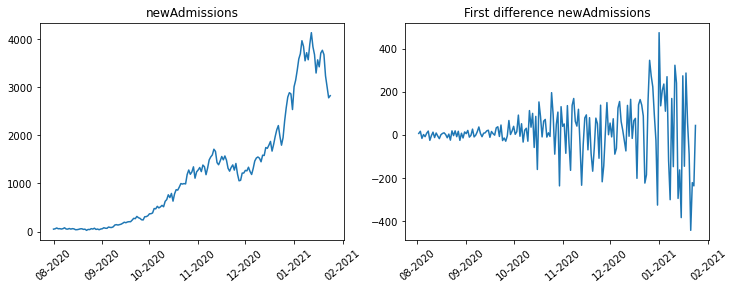

In [4]:
plot_first_diff(df, 'date', 'newAdmissions')

In [5]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, r2_score

### Forecast 2 weeks into the future

Generate forecast from the start of the year

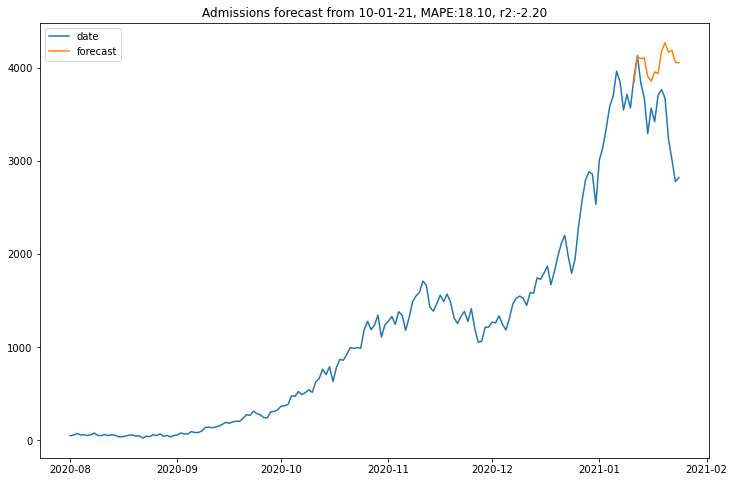

In [12]:
# Number of days to consider
n_steps = 14
timestep = relativedelta(days=1)

#Number of past datapoints used for inference
p = 12

# Date from which to forecast
train_end_date = pd.to_datetime('2021-01-10')
# Forecasted dates
forecast_dates = (timestep*np.arange(1, n_steps + 1)) + train_end_date

# Get train and test data
train_data = apply_date_selection(df, end_date=train_end_date)
test_data = apply_date_selection(df, start_date=forecast_dates[0], end_date=forecast_dates[-1])

#instantiate and fit model
model = ARIMA(train_data.newAdmissions.to_numpy(), order=(p, 1, 0)).fit()

forecast_vals = model.get_forecast(n_steps).predicted_mean

# calculate some performance metrics
forecast_mape = mean_absolute_percentage_error(test_data.newAdmissions, forecast_vals)
forecast_r2_score = r2_score(test_data.newAdmissions, forecast_vals)


plt.figure(figsize=(12,8))
plt.plot(df.date, df.newAdmissions, label='date')
plt.plot(forecast_dates,forecast_vals, label='forecast')
plt.legend()
plt.title(f'Admissions forecast from {train_end_date.strftime("%d-%m-%y")}, MAPE:{forecast_mape:.2f}, r2:{forecast_r2_score:.2f}')
plt.show()

## ARIMA results

The model captures the weekly trend successfully

#### However, the overall number of cases begins to decline after 2021-01-10
* Try forecasting 2 weeks from the 10th of January, is the forecast still consistent with the data?


The ARIMA model cannot predict when a peak is likely to turn over, i.e when the weekly average number of admissions starts to decrease.

Can we incorporate additional information into our model?

## Vector autoregression

Try incorporating information about the number of new COVID cases in England

#### Start by plotting the number of new Cases

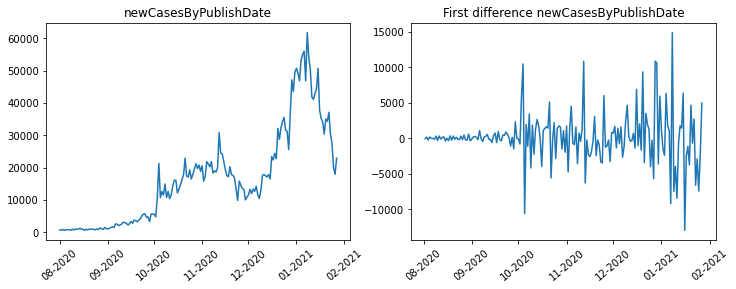

In [13]:
from statsmodels.tsa.api import VAR

plot_first_diff(df, 'date', 'newCasesByPublishDate')

/opt/anaconda/envs/Python3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


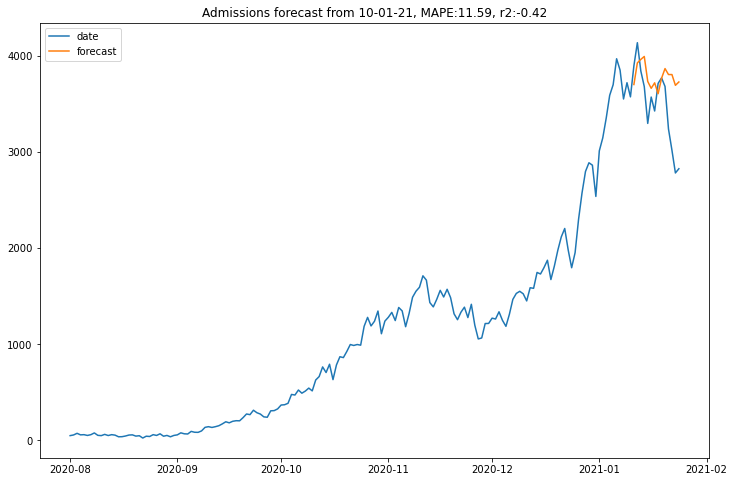

In [14]:
# Number of days to consider
n_steps = 14
timestep = relativedelta(days=1)

#Number of past datapoints used for inference
p = 12

# Date from which to forecast
train_end_date = pd.to_datetime('2021-01-10')
# Forecasted dates
forecast_dates = (timestep * np.arange(1, n_steps + 1)) + train_end_date


# Get train and test data
train_data = apply_date_selection(df, end_date=train_end_date)
test_data = apply_date_selection(df, start_date=forecast_dates[0], end_date=forecast_dates[-1])

train_data = train_data[['newAdmissions', 'newCasesByPublishDate', 'date']].set_index('date')

model_instance = VAR(train_data)
results = model_instance.fit(p)

#print(results.summary())

lag_order = results.k_ar
forecast_vals = results.forecast(train_data.values[-lag_order:], n_steps)[:, 0]

# calculate some performance metrics
forecast_mape = mean_absolute_percentage_error(test_data.newAdmissions, forecast_vals)
forecast_r2_score = r2_score(test_data.newAdmissions, forecast_vals)

plt.figure(figsize=(12,8))
plt.plot(df.date, df.newAdmissions, label='date')
plt.plot(forecast_dates, forecast_vals, label='forecast')
plt.legend()
plt.title(f'Admissions forecast from {train_end_date.strftime("%d-%m-%y")}, MAPE:{forecast_mape:.2f}, r2:{forecast_r2_score:.2f}')
plt.show()

## Using Testing data tends to improve model perforamance

#### Several other things could be done to improve the model

* The statsmodel VAR implementation does not automatically take the first difference, can try implementing it
* Could try incorporating the additional covid testing data
* Test other model hyperparameters